# INSTALL PACKAGES

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# GNN to classify breast cancer patients in LUMINAL A / Luminal B [LAB 3]

## PREPROCESSING

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import preprocessing
from scipy.stats import pearsonr


In [4]:
df = pd.read_csv("drive/MyDrive/AI for bioinformatics/LAB/LAB 3/dataset_LUMINAL_A_B.csv")
df

,l,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,...,ENSG00000088356.5,ENSG00000176752.6,ENSG00000223082.1,ENSG00000237714.1,ENSG00000200959.1,ENSG00000270971.2,ENSG00000267313.5,ENSG00000151632.15,ENSG00000269107.1,ENSG00000268889.1
0,Luminal A,2356.253792,26808.891103,57790.161586,0.0,71389.111749,381288.489078,0.0,1677.413295,1.969141e+06,...,113036.499486,0.0,20911.752405,13957.784680,1.047700e+06,0.0,1937.768563,10731.974977,0.0,0.000000
1,Luminal A,0.000000,231.960840,115769.964478,0.0,77938.573803,238017.846096,0.0,0.000000,4.865670e+06,...,850405.301444,0.0,0.000000,2122.068451,0.000000e+00,0.0,5499.352680,2479.070667,0.0,0.000000
2,Luminal A,0.000000,315.873536,44954.933833,0.0,58546.997851,249302.406604,0.0,270.107768,2.519212e+06,...,301948.579552,0.0,0.000000,481.622432,0.000000e+00,0.0,312.031830,4822.690978,0.0,0.000000
3,Luminal A,1074.333108,0.000000,86991.783442,0.0,36082.381881,176274.146728,0.0,101.975469,2.855010e+06,...,293581.147891,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,12631.387770,0.0,0.000000
4,Luminal A,1395.887715,0.000000,65199.337535,0.0,91469.201926,263704.398926,0.0,66.248682,4.235429e+06,...,350449.557585,0.0,0.000000,1181.263740,0.000000e+00,0.0,0.000000,1626.418477,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Luminal B,1145.198255,0.000000,80441.669167,0.0,88490.526118,158523.967323,0.0,27.175493,1.086328e+06,...,413667.046455,0.0,10163.634516,484.559452,0.000000e+00,0.0,0.000000,2486.701567,0.0,727.272595
96,Luminal B,0.000000,0.000000,64247.731360,0.0,44968.186413,207751.035002,0.0,908.682002,1.637001e+06,...,511495.838599,0.0,0.000000,578.660087,0.000000e+00,0.0,0.000000,1158.874086,0.0,0.000000
97,Luminal B,1584.531801,0.000000,111015.831651,0.0,106435.669012,436192.769576,0.0,12483.483824,3.462098e+06,...,482271.048999,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,6042.165123,0.0,1006.276904
98,Luminal B,0.000000,178.431416,34013.611358,0.0,35639.417589,217396.623013,0.0,0.000000,8.757449e+06,...,141814.187314,0.0,0.000000,362.746744,7.685468e+03,0.0,117.507536,1044.297168,0.0,544.444576


In [5]:
df = df.sample(frac=1) # SHUFFLING OF DATASET ROWS
df

,l,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,...,ENSG00000088356.5,ENSG00000176752.6,ENSG00000223082.1,ENSG00000237714.1,ENSG00000200959.1,ENSG00000270971.2,ENSG00000267313.5,ENSG00000151632.15,ENSG00000269107.1,ENSG00000268889.1
74,Luminal B,0.000000,79.603669,60525.579300,0.000000,58613.764264,220290.313991,0.0,54.456146,2.147436e+06,...,119467.736576,0.0,0.000000,970.993982,4114.464400,0.0,0.000000,9905.283010,0.000000,0.000000
38,Luminal A,0.000000,236.397681,56457.359456,0.000000,79929.531964,220076.666183,0.0,121.288128,3.327921e+06,...,143638.005587,0.0,0.000000,360.443067,9163.991927,0.0,175.141931,3428.806766,0.000000,540.987001
32,Luminal A,2712.471265,0.000000,79978.975557,0.000000,57017.527793,284029.527502,0.0,611.484582,3.500159e+06,...,285311.792293,0.0,0.000000,1147.708342,0.000000,0.0,1208.306456,7398.292690,0.000000,2583.883629
94,Luminal B,401.725814,55.740732,27167.766828,0.000000,63781.780263,297067.722370,0.0,1220.215307,3.263123e+06,...,239829.104632,0.0,0.000000,1699.793373,5762.127839,0.0,220.251219,13531.501463,0.000000,0.000000
52,Luminal B,0.000000,61.848883,45418.241007,0.000000,36746.522566,219188.070354,0.0,359.637198,9.354113e+06,...,119115.871944,0.0,0.000000,1131.635522,0.000000,0.0,0.000000,472.147895,0.000000,566.155160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,Luminal A,0.000000,146.181960,54243.773752,5753.946848,77943.805300,332641.156909,0.0,750.013125,8.085640e+06,...,189249.558114,0.0,0.000000,0.000000,5666.765835,0.0,0.000000,2957.235102,651.579347,0.000000
30,Luminal A,496.808009,137.867378,104019.255658,0.000000,55774.628495,278883.965574,0.0,141.470730,2.413553e+06,...,218207.625615,0.0,0.000000,0.000000,1781.483263,0.0,0.000000,18155.023377,0.000000,1893.025149
28,Luminal A,0.000000,0.000000,49410.433167,0.000000,76185.343543,406905.112244,0.0,139.320719,1.983987e+06,...,271917.597146,0.0,0.000000,828.064343,12280.863345,0.0,67.060423,4197.704361,0.000000,1242.837180
51,Luminal B,0.000000,0.000000,115939.159122,0.000000,97148.626331,197179.900505,0.0,177.495804,6.747133e+06,...,359360.954156,0.0,3319.171535,0.000000,0.000000,0.0,102.522673,396.141612,0.000000,1425.046813


In [6]:
y = df.l

X = df.drop(labels=['l'], axis=1)
X_scaled = preprocessing.StandardScaler().fit_transform(X) # SCALING DATA
X = pd.DataFrame(X_scaled, columns=X.columns)

y = preprocessing.LabelEncoder().fit_transform(y) #luminal A = 0, luminal B = 1
y

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

## GNN

###PEARSON CORRELATION

In [7]:
corr_list = []

for i in range(X.shape[0]):
  for j in range(X.shape[0]):
    if i!=j:
      corr, _ = pearsonr(X.iloc[i], X.iloc[j])
      corr_list.append([i, j, corr])

#corr_list

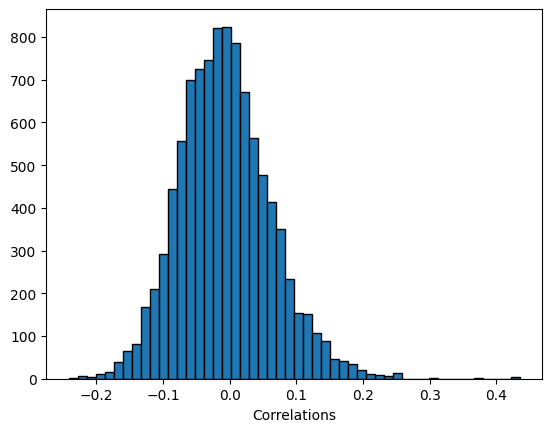

In [8]:
# PLOT CORRELATIONS
correlations = [item[2] for item in corr_list]

plt.hist(correlations, bins=50, edgecolor="black")
plt.xlabel('Correlations')
plt.show()

In [9]:
#CORRELATIONS > 0
corr_list_copy = corr_list.copy()
threshold = 0

# Remove data with correlation lower than 0
for value in corr_list.copy():
  if value[2] < threshold:
    corr_list_copy.remove(value)

corr_list = corr_list_copy

print("Threshold: ", threshold)
print(f'Average node degree: {len(corr_list)/X.shape[0]:.2f}')
print(f'Number of edges: {len(corr_list)}')
print(f'Number of nodes: {X.shape[0]}')

Threshold:  0
Average node degree: 43.04
Number of edges: 4304
Number of nodes: 100


###EDGES CREATION

In [10]:
edge_index = [[item[0], item[1]] for item in corr_list]
edge_index

[[0, 1],
 [0, 4],
 [0, 6],
 [0, 9],
 [0, 11],
 [0, 12],
 [0, 16],
 [0, 18],
 [0, 20],
 [0, 22],
 [0, 25],
 [0, 26],
 [0, 32],
 [0, 33],
 [0, 35],
 [0, 38],
 [0, 42],
 [0, 43],
 [0, 46],
 [0, 49],
 [0, 50],
 [0, 51],
 [0, 52],
 [0, 55],
 [0, 56],
 [0, 57],
 [0, 59],
 [0, 61],
 [0, 62],
 [0, 63],
 [0, 65],
 [0, 67],
 [0, 68],
 [0, 69],
 [0, 73],
 [0, 74],
 [0, 75],
 [0, 76],
 [0, 77],
 [0, 79],
 [0, 80],
 [0, 81],
 [0, 84],
 [0, 85],
 [0, 91],
 [0, 92],
 [0, 94],
 [0, 99],
 [1, 0],
 [1, 2],
 [1, 4],
 [1, 10],
 [1, 12],
 [1, 15],
 [1, 18],
 [1, 19],
 [1, 22],
 [1, 23],
 [1, 25],
 [1, 26],
 [1, 28],
 [1, 31],
 [1, 32],
 [1, 34],
 [1, 37],
 [1, 38],
 [1, 41],
 [1, 43],
 [1, 45],
 [1, 47],
 [1, 48],
 [1, 51],
 [1, 55],
 [1, 57],
 [1, 59],
 [1, 60],
 [1, 61],
 [1, 63],
 [1, 67],
 [1, 69],
 [1, 70],
 [1, 73],
 [1, 74],
 [1, 76],
 [1, 78],
 [1, 85],
 [1, 86],
 [1, 87],
 [1, 90],
 [1, 91],
 [1, 96],
 [1, 97],
 [1, 99],
 [2, 1],
 [2, 6],
 [2, 12],
 [2, 13],
 [2, 14],
 [2, 16],
 [2, 21],
 [2, 22],

In [11]:
from torch_geometric.data import Data

TEST_SAMPLES = 20

# Create a Data object. All data converted in tensor array.
data = Data(x=torch.tensor(X.values).to(torch.float32),
            edge_index=torch.tensor(np.transpose(np.array(edge_index))),
            y=torch.tensor(y),
            train_mask=torch.tensor([i for i in range(0, X.shape[0]-TEST_SAMPLES)]),
            test_mask=torch.tensor([i for i in range(X.shape[0]-TEST_SAMPLES, X.shape[0])]))
print(data)

Data(x=[100, 1022], edge_index=[2, 4304], y=[100], train_mask=[80], test_mask=[20])


In [12]:
# Graph information
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Training node label rate: 31.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


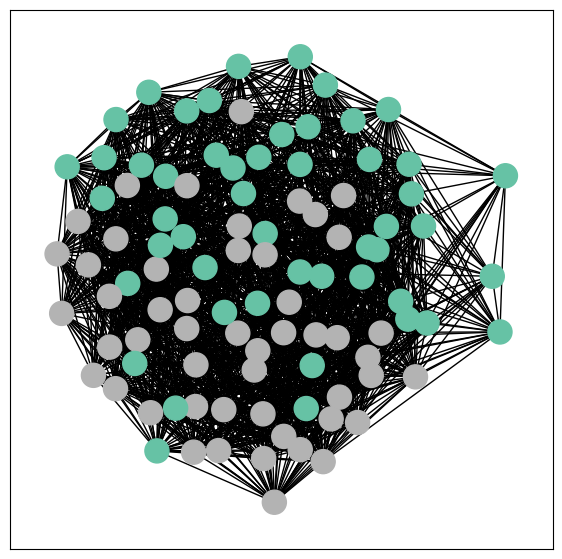

In [13]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

###GCN

In [14]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)
        self.classifier = Linear(2, 2)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN(hidden_channels = 16)
print(model)

GCN(
  (conv1): GCNConv(1022, 16)
  (conv2): GCNConv(16, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


Embedding shape: [100, 2]


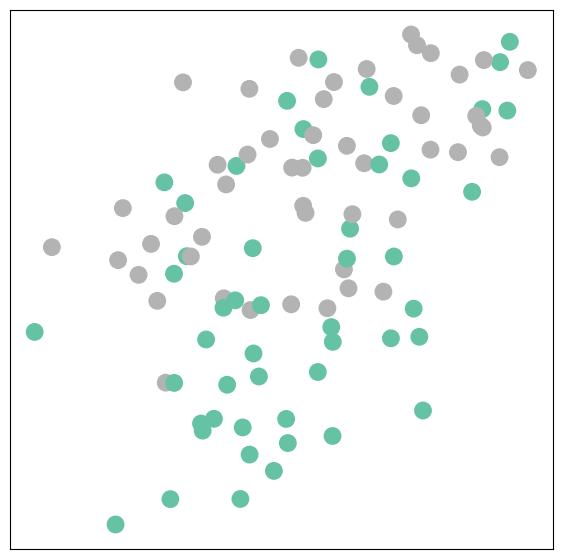

In [15]:
model = GCN(hidden_channels = 16)
model.eval()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

In [16]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN(hidden_channels = 16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

def test():
      model.eval()
      out, h = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / TEST_SAMPLES  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(101):
    loss, h = train(data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 000, Loss: 0.7416
Epoch: 001, Loss: 0.7031
Epoch: 002, Loss: 0.6477
Epoch: 003, Loss: 0.6424
Epoch: 004, Loss: 0.6244
Epoch: 005, Loss: 0.6148
Epoch: 006, Loss: 0.5968
Epoch: 007, Loss: 0.5874
Epoch: 008, Loss: 0.5901
Epoch: 009, Loss: 0.5833
Epoch: 010, Loss: 0.5656
Epoch: 011, Loss: 0.5535
Epoch: 012, Loss: 0.5597
Epoch: 013, Loss: 0.5492
Epoch: 014, Loss: 0.5400
Epoch: 015, Loss: 0.5434
Epoch: 016, Loss: 0.5283
Epoch: 017, Loss: 0.5252
Epoch: 018, Loss: 0.5202
Epoch: 019, Loss: 0.5075
Epoch: 020, Loss: 0.5015
Epoch: 021, Loss: 0.5055
Epoch: 022, Loss: 0.4923
Epoch: 023, Loss: 0.4926
Epoch: 024, Loss: 0.4995
Epoch: 025, Loss: 0.4790
Epoch: 026, Loss: 0.4621
Epoch: 027, Loss: 0.4601
Epoch: 028, Loss: 0.4647
Epoch: 029, Loss: 0.4606
Epoch: 030, Loss: 0.4531
Epoch: 031, Loss: 0.4430
Epoch: 032, Loss: 0.4318
Epoch: 033, Loss: 0.4156
Epoch: 034, Loss: 0.4178
Epoch: 035, Loss: 0.4620
Epoch: 036, Loss: 0.4142
Epoch: 037, Loss: 0.4217
Epoch: 038, Loss: 0.4078
Epoch: 039, Loss: 0.4003


In [17]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9500


Embedding shape: [100, 2]


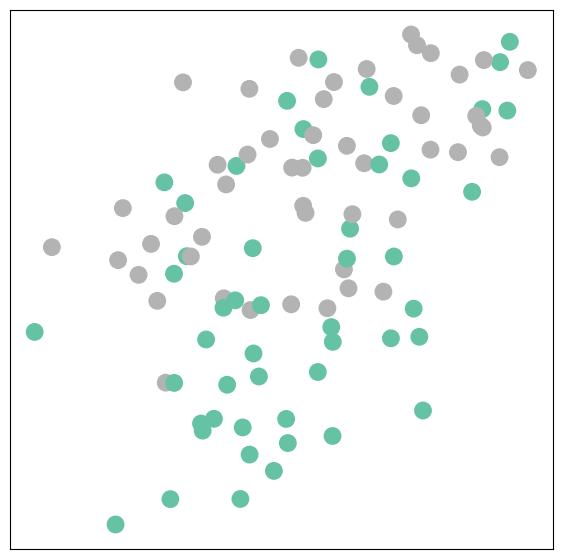

In [18]:
model = GCN(hidden_channels = 16)
model.eval()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

## MLP

In [19]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, 2)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1022, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [20]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / TEST_SAMPLES # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.7117
Epoch: 002, Loss: 0.4959
Epoch: 003, Loss: 0.3162
Epoch: 004, Loss: 0.2319
Epoch: 005, Loss: 0.1696
Epoch: 006, Loss: 0.1739
Epoch: 007, Loss: 0.1018
Epoch: 008, Loss: 0.0924
Epoch: 009, Loss: 0.0513
Epoch: 010, Loss: 0.0670
Epoch: 011, Loss: 0.0419
Epoch: 012, Loss: 0.0359
Epoch: 013, Loss: 0.0315
Epoch: 014, Loss: 0.0322
Epoch: 015, Loss: 0.0290
Epoch: 016, Loss: 0.0471
Epoch: 017, Loss: 0.0264
Epoch: 018, Loss: 0.0330
Epoch: 019, Loss: 0.0225
Epoch: 020, Loss: 0.0349
Epoch: 021, Loss: 0.0296
Epoch: 022, Loss: 0.0307
Epoch: 023, Loss: 0.0225
Epoch: 024, Loss: 0.0138
Epoch: 025, Loss: 0.0380
Epoch: 026, Loss: 0.0147
Epoch: 027, Loss: 0.0475
Epoch: 028, Loss: 0.0363
Epoch: 029, Loss: 0.0135
Epoch: 030, Loss: 0.0171
Epoch: 031, Loss: 0.0156
Epoch: 032, Loss: 0.0109
Epoch: 033, Loss: 0.0224
Epoch: 034, Loss: 0.0175
Epoch: 035, Loss: 0.0138
Epoch: 036, Loss: 0.0248
Epoch: 037, Loss: 0.0129
Epoch: 038, Loss: 0.0314
Epoch: 039, Loss: 0.0457
Epoch: 040, Loss: 0.0201


In [21]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9000
